In [9]:
import os
import numpy as np
from motion_planning.utils import parse_arguments, GIBSON_ROOT
import matplotlib.pyplot as plt

In [10]:
perception_name = 'rgb_test'

In [12]:
dataset_path = os.path.join(GIBSON_ROOT, 'log', perception_name, 'mujoco_latents/latents.pkl')
latents, target_coords = np.load(dataset_path)
latents = latents[:, 0, :]

print('latents shape ', latents.shape)
print('target_coords ', target_coords.shape)

('latents shape ', (1400, 10))
('target_coords ', (1400, 2))


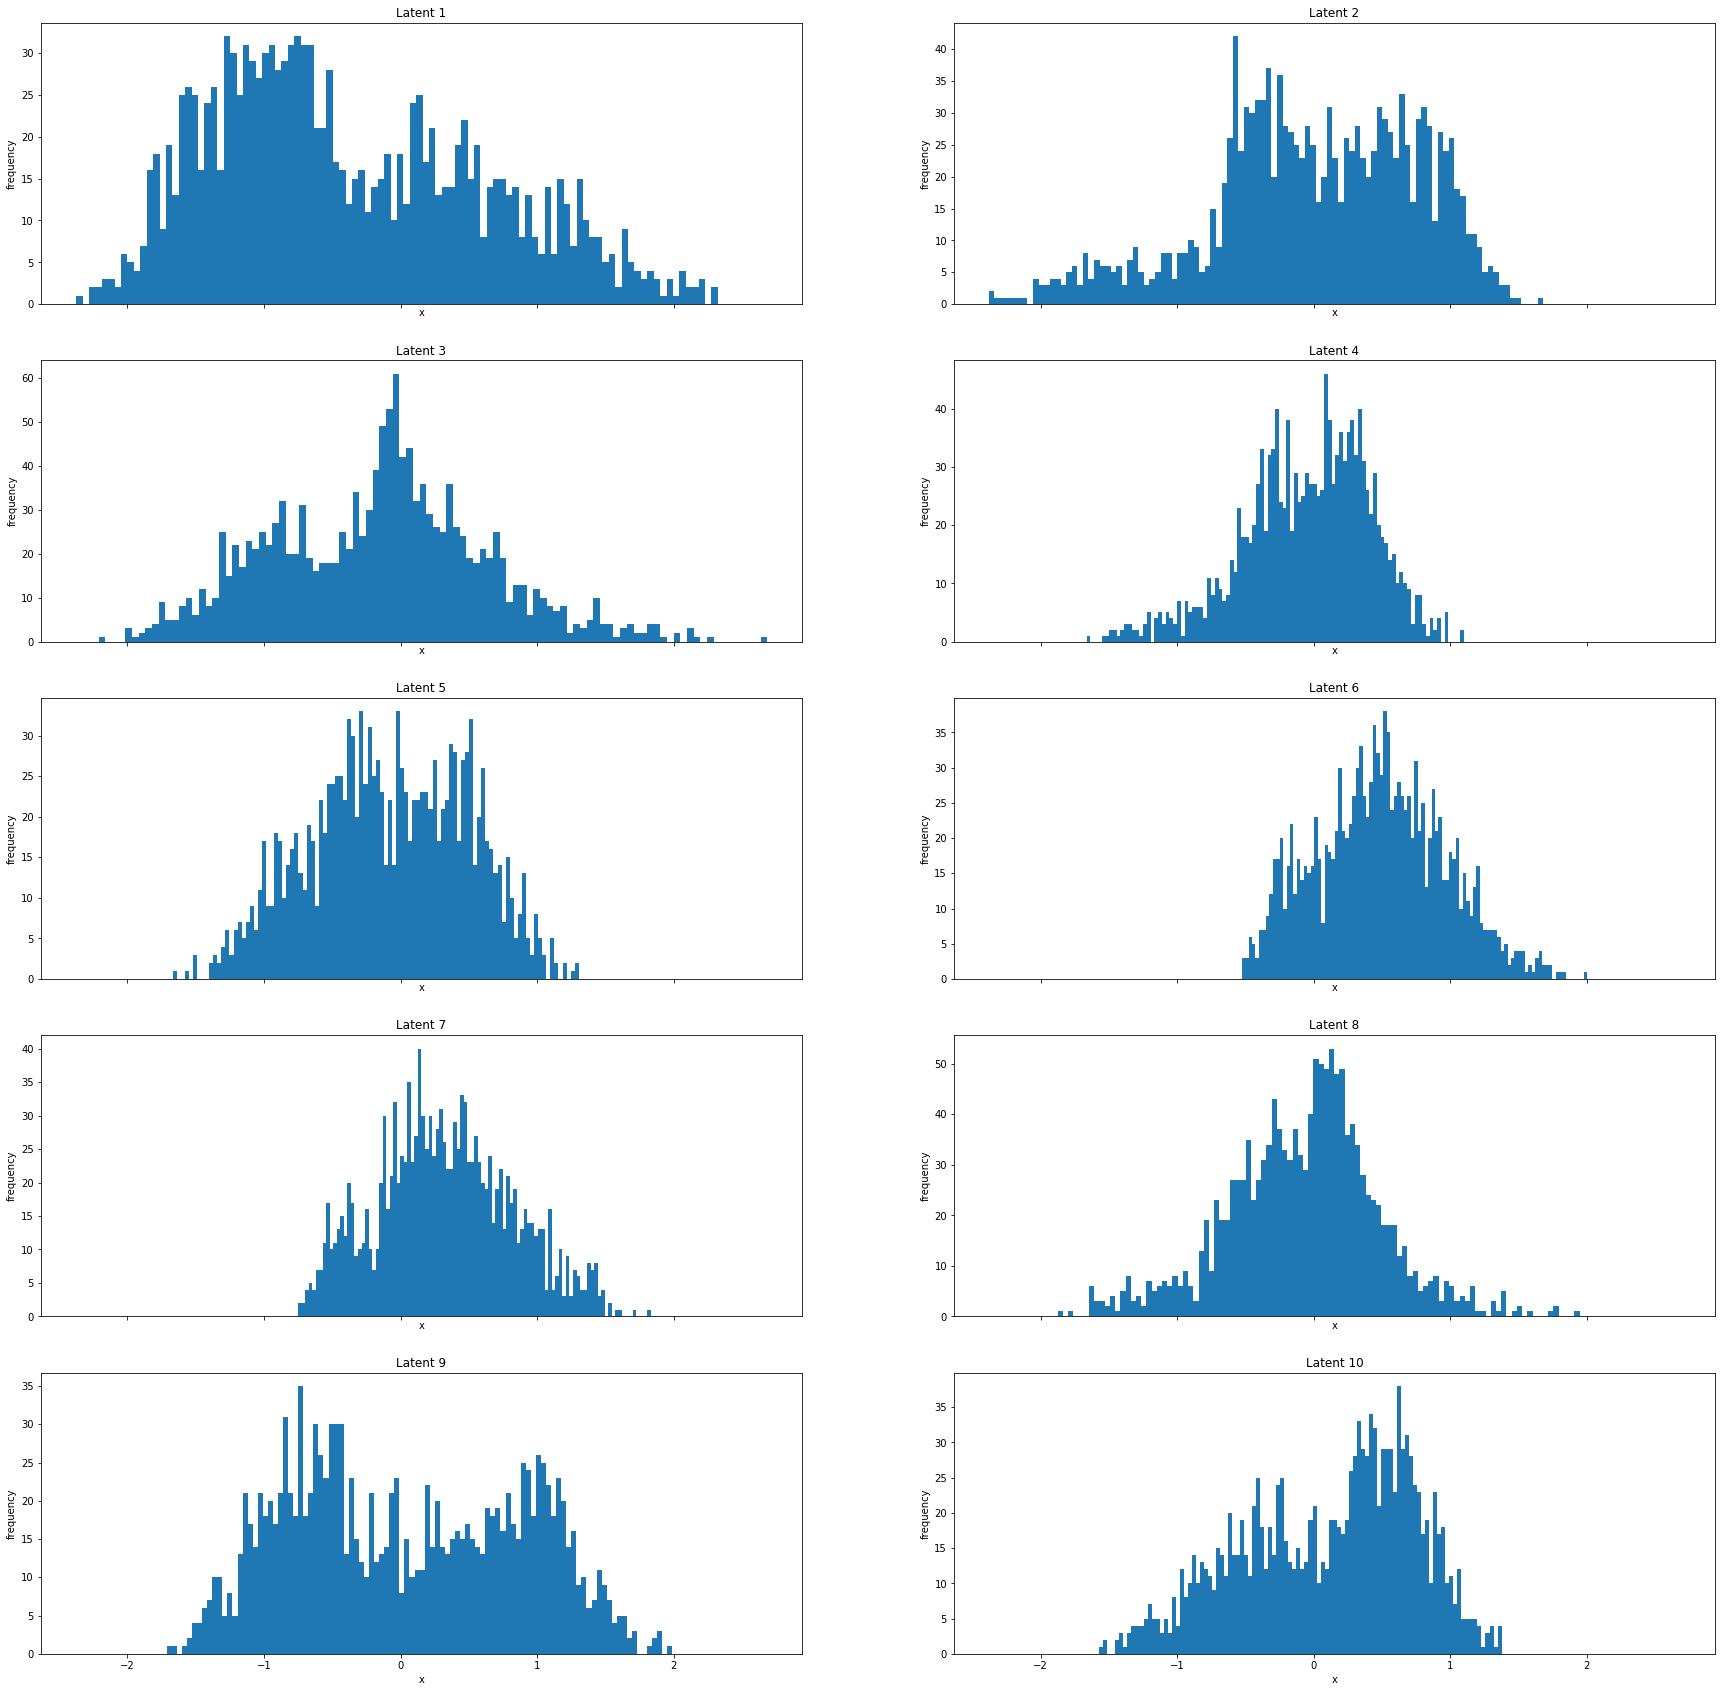

In [13]:
fig, axes = plt.subplots(latents.shape[1] / 2, 2, sharex=True, figsize=[30, 30])
for i in range(latents.shape[1]):
    ax = axes[int(i/2)][i%2]
    batch = latents[:, i]
    ax.hist(batch, bins=100)
    ax.set_title('Latent {}'.format(i + 1))
    ax.set_xlabel('x')
    ax.set_ylabel('frequency')

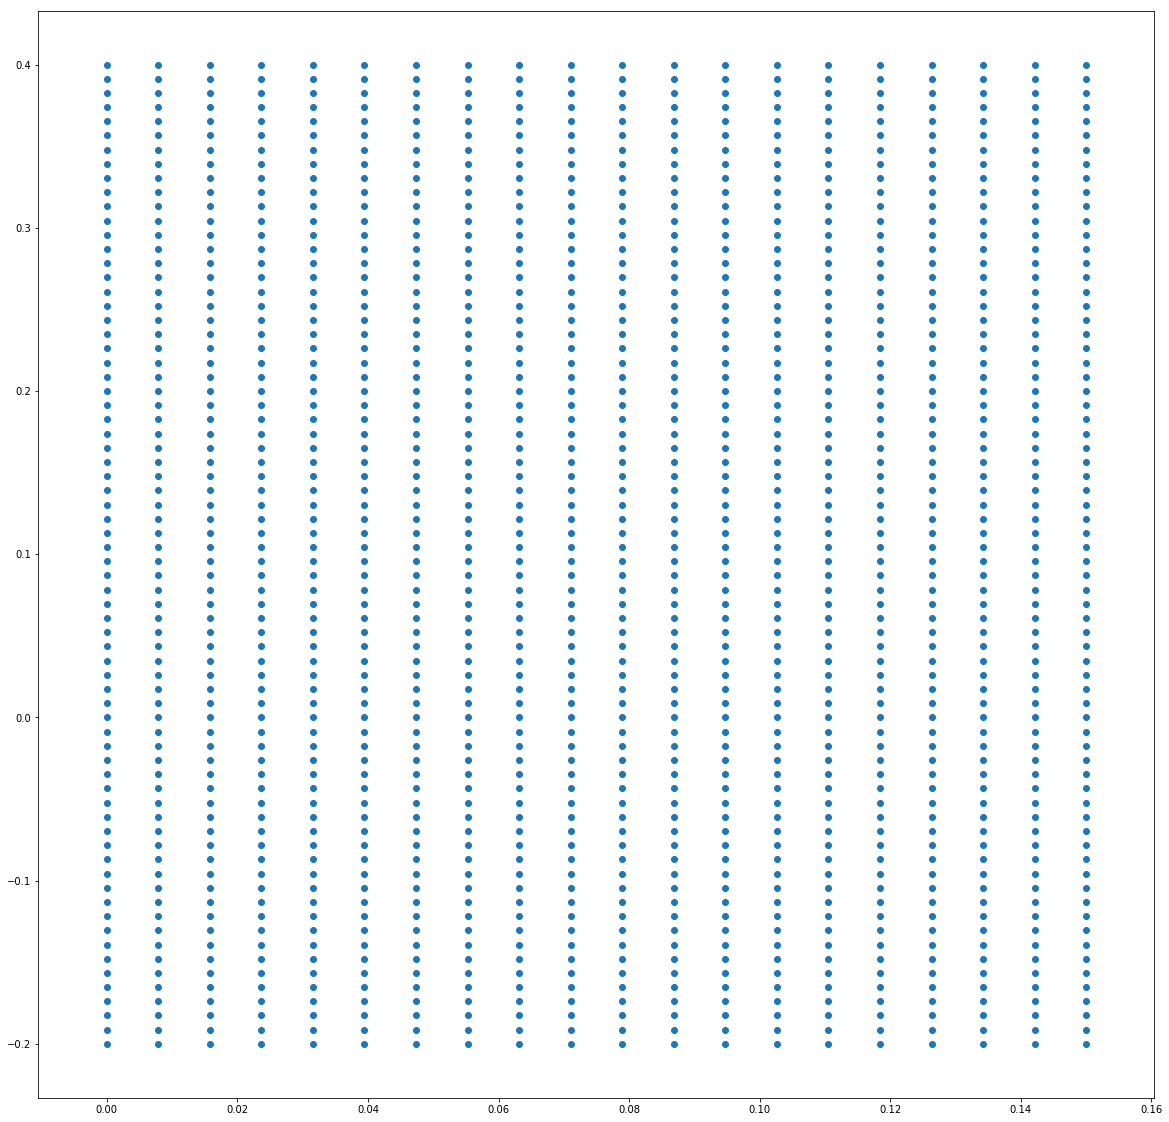

In [8]:

plt.figure(figsize=(20, 20))
plt.scatter(target_coords[:,0], target_coords[:,1])

In [14]:


print('Dataset error: ')
print(np.linalg.norm(target_coords[0] - target_coords[1]))
print(np.linalg.norm(target_coords[0] - target_coords[70]))

Dataset error: 
0.008695652173913049
0.007894736842105263


In [15]:
# perception_test.py
X_LIMITS = [0.0, 0.15]
Y_LIMITS = [-0.20, 0.40]

def get_centers_indices(poses, steps, x_divide, y_divide):
    
    if (x_divide):
        X_C = np.linspace(X_LIMITS[0], X_LIMITS[1], 2 + steps)
    else:
        X_C = np.linspace(X_LIMITS[0], X_LIMITS[1], 2 + 1)
    
    X_C = X_C[1:-1]
    
    if (y_divide):
        Y_C = np.linspace(Y_LIMITS[0], Y_LIMITS[1], 2 + steps)
    else:
        Y_C = np.linspace(Y_LIMITS[0], Y_LIMITS[1], 2 + 1)
        
    Y_C = Y_C[1:-1]
    
    center_indices = []
    for y in Y_C:
        for x in X_C:
            center_indices.append(np.argmin(np.linalg.norm(poses[:, :2] - np.array((x, y)), axis=1)))    
    return np.array(center_indices)

In [16]:

def create_clusters(pose_results, latents, steps, x_divide=True, y_divide=True):

    indices = get_centers_indices(pose_results, steps, x_divide, y_divide)
    
    num_samples = latents.shape[0]
    
    center_dists = np.zeros((indices.shape[0], num_samples))
    
    for idx in range(indices.shape[0]):
        
        center_dists[idx] = np.linalg.norm(latents - latents[indices[idx]], axis=1)

    labels = np.argmin(center_dists, axis=0)

    plt.figure(figsize=(5, 10))

    for idx in range(indices.shape[0]):
        labeled_end_poses = pose_results[(labels == idx)]
        plt.scatter(labeled_end_poses[:,0], labeled_end_poses[:,1])
        
    title = "The number of clusters {}".format(indices.shape[0])
    
    if (x_divide):
        title += " x axis dividided"
        
    if (y_divide):
        title += " y axis dividided"
        
    plt.title(title)
    
    return labels

array([1, 1, 1, ..., 1, 1, 1])

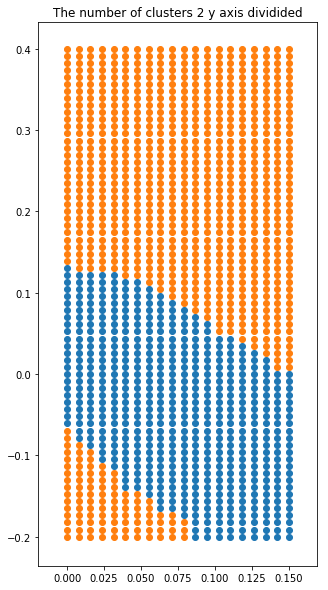

In [40]:
# y divided

create_clusters(target_coords, latents, 2, x_divide=False, y_divide=True)

array([1, 1, 3, ..., 0, 1, 1])

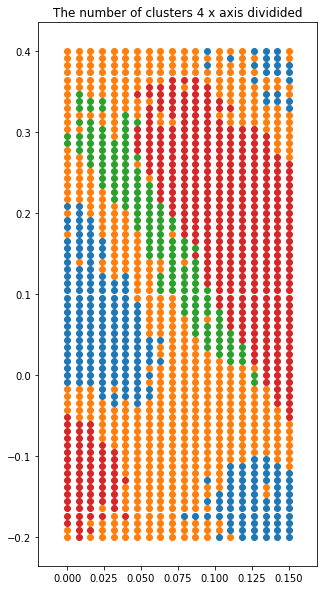

In [41]:
# X divided:
create_clusters(target_coords, latents, 4, x_divide=True, y_divide=False)

array([3, 3, 3, ..., 3, 3, 0])

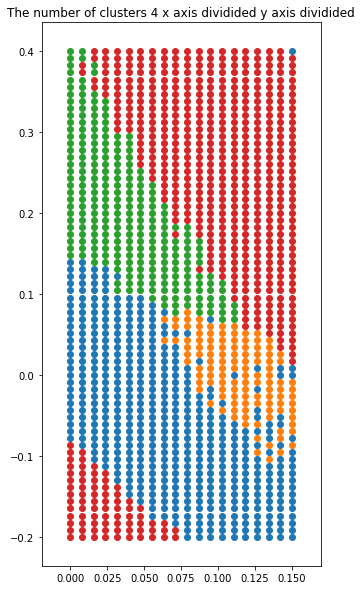

In [42]:
# X divided:
create_clusters(target_coords, latents, 2, x_divide=True, y_divide=True)

In [17]:
# from sklearn.cluster import KMeans
from sklearn.cluster import KMeans


def kmean_clustering(coords, latents, num_clusters):
    
    clf = KMeans(n_clusters=num_clusters, n_init=100)
    labels = clf.fit_predict(latents)
    
    plt.figure(figsize=(5, 10))

    for idx in range(num_clusters):
        labeled_end_poses = coords[(labels == idx)]
        plt.scatter(labeled_end_poses[:,0], labeled_end_poses[:,1])
        
    title = "KMEAN clustering with k {}".format(num_clusters)        
    plt.title(title)    
    
    return labels


array([3, 3, 3, ..., 3, 3, 3], dtype=int32)

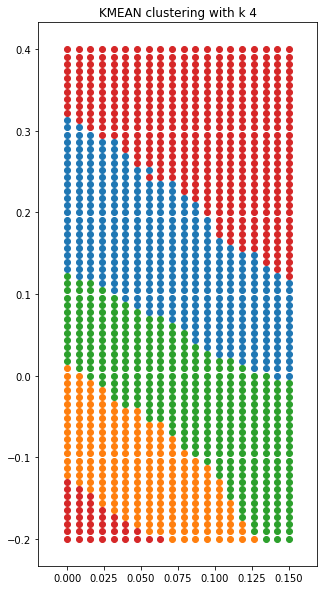

In [23]:
# KDMean:
kmean_clustering(target_coords, latents, 4)